In [ ]:
pip install attention


In [ ]:
import pandas as pd
import numpy as np
from attention import Attention
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
data = pd.read_csv('/content/Datasets-kathmandu.csv')

In [ ]:
data

,ds,y
0,2016-01-01,191.231263
1,2016-01-02,183.040896
2,2016-01-03,195.495871
3,2016-01-04,193.733857
4,2016-01-05,193.534451
...,...,...
3343,2025-02-24 00:00:00,427.714658
3344,2025-02-25 00:00:00,426.197738
3345,2025-02-26 00:00:00,422.415028
3346,2025-02-27 00:00:00,413.379246


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['y'].values.reshape(-1,1))
unscaled_data = scaler.inverse_transform(scaled_data)
scaled_data

array([[0.28262424],
       [0.2646923 ],
       [0.29196114],
       ...,
       [0.78877635],
       [0.76899347],
       [0.78141847]])

In [ ]:
data['ds'] = pd.to_datetime(data['ds'])

# Define the split dates
train_end_date = '2021-08-01'
test_end_date = '2023-02-28'

# Split the data based on the defined dates
train_data = scaled_data[data['ds'] <= train_end_date]
test_data = scaled_data[(data['ds'] > train_end_date) & (data['ds'] <= test_end_date)]
forecast_data = scaled_data[data['ds'] > test_end_date]

In [ ]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 80
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)
X_forecast, y_forecast = create_sequences(forecast_data, sequence_length)

# check the shape of the data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1960, 80, 1)
(1960, 1)
(497, 80, 1)
(497, 1)


In [ ]:
data['ds'] = pd.to_datetime(data['ds'])

test_end_date = '2023-02-28'

# Split the data based on the defined dates
data = data[data['ds'] <= test_end_date]
data

,ds,y
0,2016-01-01,191.231263
1,2016-01-02,183.040896
2,2016-01-03,195.495871
3,2016-01-04,193.733857
4,2016-01-05,193.534451
...,...,...
2612,2023-02-25,375.120000
2613,2023-02-26,369.380000
2614,2023-02-27,369.170000
2615,2023-02-28,358.010000


In [ ]:
inputs = Input(shape=(sequence_length, 1))
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(inputs)
attention_out = Attention(32)(lstm_out)
outputs = Dense(1)(attention_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model with validation
history = model.fit(X_train, y_train, epochs=100, batch_size=80 , validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0118
Epoch 1: val_loss improved from inf to 0.00635, saving model to best_model.h5
25/25 [==============================] - 6s 46ms/step - loss: 0.0109 - val_loss: 0.0063
Epoch 2/100
11/25 [============>.................] - ETA: 0s - loss: 0.0026

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/25 [========================>.....] - ETA: 0s - loss: 0.0025
Epoch 2: val_loss improved from 0.00635 to 0.00439, saving model to best_model.h5
25/25 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0044
Epoch 3/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 3: val_loss improved from 0.00439 to 0.00269, saving model to best_model.h5
25/25 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 4/100
21/25 [========================>.....] - ETA: 0s - loss: 7.6223e-04
Epoch 4: val_loss improved from 0.00269 to 0.00221, saving model to best_model.h5
25/25 [==============================] - 0s 14ms/step - loss: 7.2972e-04 - val_loss: 0.0022
Epoch 5/100
24/25 [===========================>..] - ETA: 0s - loss: 5.5364e-04
Epoch 5: val_loss did not improve from 0.00221
25/25 [==============================] - 0s 12ms/step - loss: 5.4893e-04 - val_loss: 0.0023
Epoch 6/100
24/25 [===========================>

In [ ]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

Train Loss: 0.00042251439299434423
Test Loss: 0.0016008534003049135


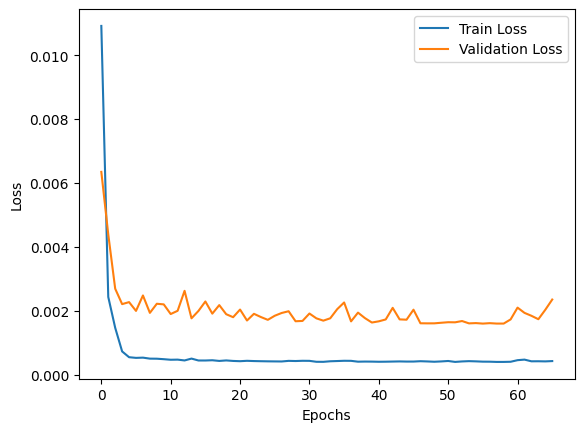

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 [==============================] - 1s 8ms/step


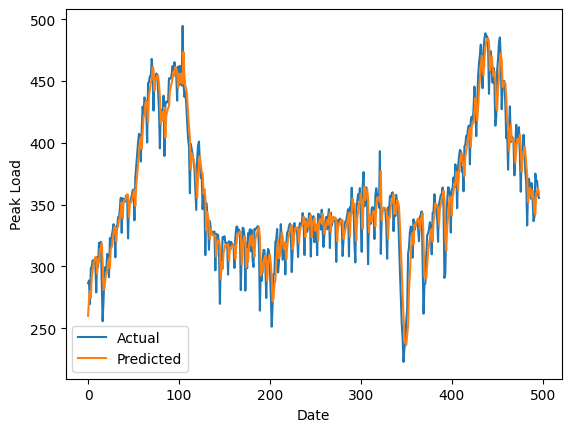

In [ ]:
# Load the best model
best_model = Model(inputs=inputs, outputs=outputs)
best_model.load_weights('best_model.h5')

# Test the best model on unseen data
predicted = best_model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

# Plot the predicted results and actual values
plt.plot(y_test, label='Actual')
plt.plot(predicted, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Peak Load')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Data vs Time')

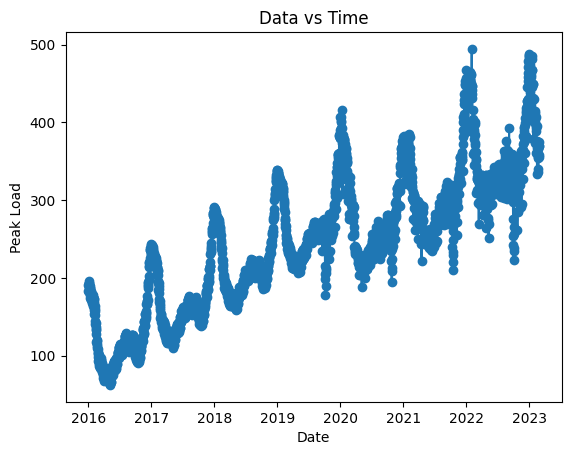

In [ ]:
plt.plot(data['ds'], data['y'], marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Peak Load')
plt.title('Data vs Time')

In [ ]:
data.tail()

,ds,y
2612,2023-02-25,375.120000
2613,2023-02-26,369.380000
2614,2023-02-27,369.170000
2615,2023-02-28,358.010000
2616,2023-02-28,355.390826


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Making predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# print("Y train",y_train)
# print("Y test",y_test)
# print("Y train pred",y_train_pred)
# print("Y test pred",y_test_pred)
# y_test = scaler.transform(y_test)
y_test_pred = scaler.inverse_transform(y_test_pred)
# # print(y_test)
# Calculate MAE


16/16 [==============================] - 0s 9ms/step


In [ ]:

print(y_test.shape)

(497, 1)


In [ ]:
y_test_pred = y_test_pred[:, 0].reshape(-1, 1)
y_train_pred = y_train_pred[:, 0].reshape(-1, 1)
y_test_pred.shape

(497, 1)

In [ ]:
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Calculate R^2
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)


<ipython-input-108-be8b0df5a208>:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
print("Test MAE:", test_mae)
print("Test MAPE:", test_mape)
print("Test R^2:", test_r2)

Test MAE: 13.794711054520707
Test MAPE: 4.040240464061542
Test R^2: 0.8809217358668311


In [ ]:
y_forecast = best_model.predict(X_forecast)

21/21 [==============================] - 0s 11ms/step


In [ ]:
y_forecast = scaler.inverse_transform(y_forecast)
y_forecast = y_forecast[:, 0].reshape(-1, 1)

In [ ]:
y_forecast.shape


(651, 1)

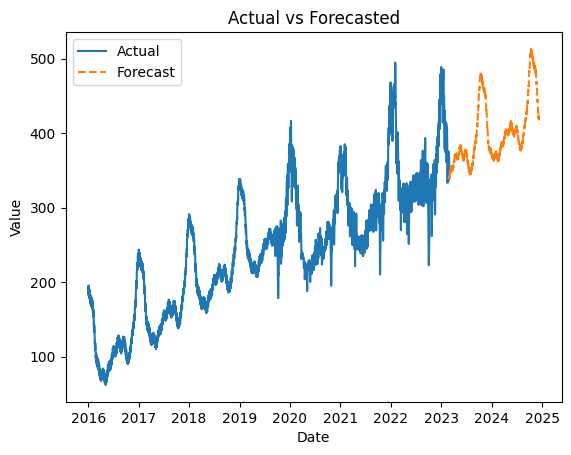

In [ ]:
import pandas as pd

y_forecast = y_forecast.flatten()

dates = pd.date_range(start='2023-03-01', periods=len(y_forecast), freq='D')

forecast_df = pd.DataFrame({'ds': dates, 'y': y_forecast})

plt.plot(data['ds'], data['y'], label='Actual')
plt.plot(forecast_df['ds'], forecast_df['y'], label='Forecast', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted')
plt.legend()

# Show plot
plt.show()
